# Ryzen AI CVML Library

The Ryzen AI Computer Vision and Machine Learning (CVML) library provides optimized, ready-to-use computer vision features that can run on multiple hardware backends including the NPU, GPU, and CPU.

## Goals

* Learn about the Ryzen AI CVML library features
* Run depth estimation on a single image
* Process video with different hardware backends
* Measure power and performance differences between NPU and GPU

## References

* [Ryzen AI CVML library](https://ryzenai.docs.amd.com/en/latest/ryzen_ai_libraries.html)
* [Ryzen AI GitHub](https://github.com/amd/RyzenAI-SW/tree/main/Ryzen-AI-CVML-Library)

## What is CVML?

The Ryzen AI CVML library provides:

- **Ready-to-use CV features**: Depth estimation, face detection, face mesh
- **Optimized models**: Pre-quantized INT8 models for NPU execution
- **Low power consumption**: NPU provides hardware acceleration with minimal power draw

The features are implemented as a C++ library.

## Building CVML Samples

We've created CVML samples with separate NPU and CPU backend binaries. Let's build them:

In [1]:
!cd cvml_samples && ./build.sh

Building CVML samples...
Running CMake...
-- The C compiler identification is GNU 13.3.0
-- The CXX compiler identification is GNU 13.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenCV: /usr (found version "4.6.0") 
-- Found RyzenAILibrary: /ryzers/notebooks/Ryzen-AI-CVML-Library/linux/libcvml-depth-estimation.so;/ryzers/notebooks/Ryzen-AI-CVML-Library/linux/libcvml-face-detector.so;/ryzers/notebooks/Ryzen-AI-CVML-Library/linux/libcvml-facemesh.so;/ryzers/notebooks/Ryzen-AI-CVML-Library/linux/libcvml-sdk.so  
-- Configuring done (0.2s)
-- Generating done (0.0s)
-- Build files have been written to: /ryzers/notebooks

## Running Depth Estimation on an Image

In [2]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Extract first frame from video
video_path = 'Ryzen-AI-CVML-Library/samples/video_call.mp4'
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()
cv2.imwrite('test_frame.jpg', frame);

Run NPU Depth Estimation on the test image

[INFO] time:117658921 thread:123700044909952 AMD CVML SDK: 0.0.0-dev
[INFO] time:117658921 thread:123700044909952 Any GPU inference will use AMD Radeon Graphics (RADV GFX1151)[0]
Using NPU backend
[INFO] time:117658928 thread:123700044909952 [Depth Estimation] Using ONNX engine, NPU backend
Image file read: test_frame.jpg
I20251014 05:46:58.600685  2363 vitisai_compile_model.cpp:1143] Vitis AI EP Load ONNX Model Success
I20251014 05:46:58.600744  2363 vitisai_compile_model.cpp:1144] Graph Input Node Name/Shape (1)
I20251014 05:46:58.600754  2363 vitisai_compile_model.cpp:1148] 	 efficient_Unet::input_0_nhwc : [1x256x256x3]
I20251014 05:46:58.600759  2363 vitisai_compile_model.cpp:1154] Graph Output Node Name/Shape (1)
I20251014 05:46:58.600761  2363 vitisai_compile_model.cpp:1158] 	 2196_nhwc : [1x256x256x1]
[Vitis AI EP] No. of Operators :   CPU     2    NPU   616 
[Vitis AI EP] No. of Subgraphs :   NPU     1 Actually running on NPU     1 
[INFO] time:117659412 thread:123699774305984 

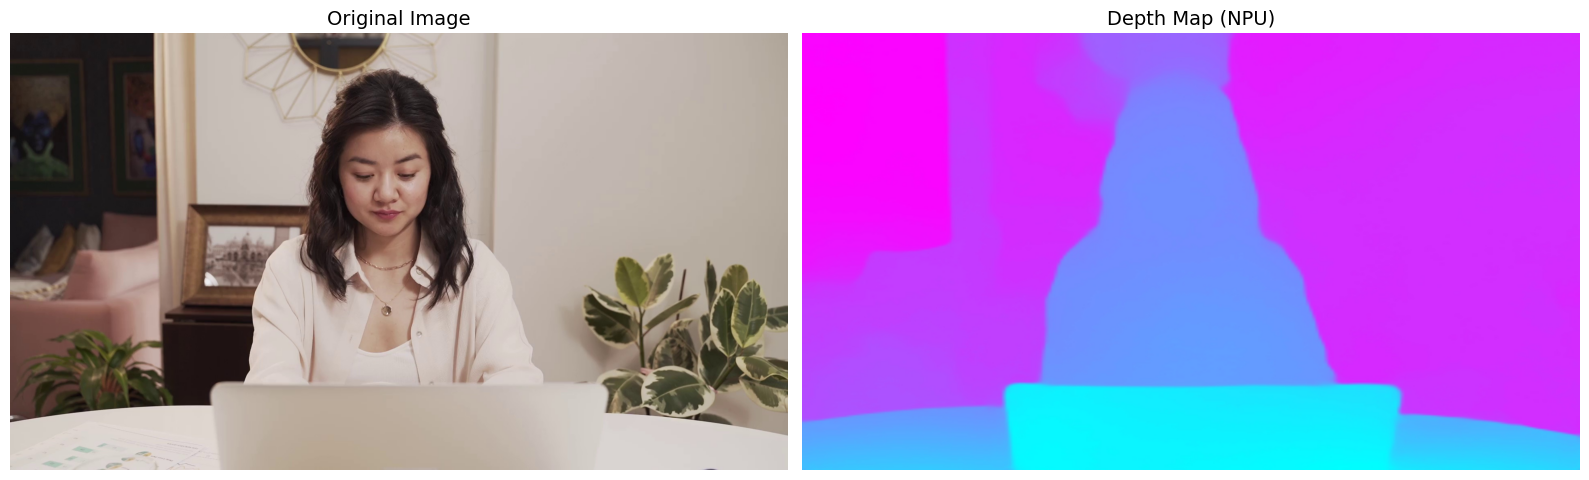

In [3]:
!./build/depth_estimation_npu -i test_frame.jpg -o depth_npu.jpg

# Load and display side-by-side comparison
original = cv2.imread('test_frame.jpg')
depth = cv2.imread('depth_npu.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=14)
ax1.axis('off')

ax2.imshow(cv2.cvtColor(depth, cv2.COLOR_BGR2RGB))
ax2.set_title('Depth Map (NPU)', fontsize=14)
ax2.axis('off')

plt.tight_layout()
plt.savefig('depth_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Video Processing with Power Measurement

Now let's process the full video and monitor power consumption during inference.

### NPU Video Processing

We'll run the NPU version while monitoring power with `rocm-smi`:

In [4]:
import subprocess
import threading
import time
import re
import os

def monitor_power():
    """Monitor power consumption using rocm-smi"""
    global monitoring, power_samples
    while monitoring:
        try:
            result = subprocess.run(
                ['rocm-smi', '--showpower'],
                capture_output=True,
                text=True,
                timeout=2
            )
            match = re.search(r'Power \(W\): (\d+\.\d+)', result.stdout)
            if match:
                power_samples.append(float(match.group(1)))
        except:
            pass
        time.sleep(0.5)  # Sample every 500ms

# Storage for power measurements
power_samples = []
monitoring = True

# Start power monitoring
print("Starting NPU depth estimation with power monitoring...\n")
monitor_thread = threading.Thread(target=monitor_power, daemon=True)
monitor_thread.start()

start = time.time()
subprocess.run([
    './build/depth_estimation_npu',
    '-i', 'Ryzen-AI-CVML-Library/samples/video_call.mp4',
    '-o', 'output_npu.mp4'
], env={**os.environ, 'QT_QPA_PLATFORM': 'offscreen'})
npu_duration = time.time() - start

# Stop monitoring
monitoring = False
monitor_thread.join(timeout=5)

print(f"Elapsed time: {npu_duration:.2f} seconds")

Starting NPU depth estimation with power monitoring...

[INFO] time:117660315 thread:123804517211520 AMD CVML SDK: 0.0.0-dev
[INFO] time:117660315 thread:123804517211520 Any GPU inference will use AMD Radeon Graphics (RADV GFX1151)[0]
Using NPU backend
[INFO] time:117660322 thread:123804517211520 [Depth Estimation] Using ONNX engine, NPU backend
Opening video file: Ryzen-AI-CVML-Library/samples/video_call.mp4


I20251014 05:46:59.989127  2518 vitisai_compile_model.cpp:1143] Vitis AI EP Load ONNX Model Success
I20251014 05:46:59.989179  2518 vitisai_compile_model.cpp:1144] Graph Input Node Name/Shape (1)
I20251014 05:46:59.989187  2518 vitisai_compile_model.cpp:1148] 	 efficient_Unet::input_0_nhwc : [1x256x256x3]
I20251014 05:46:59.989192  2518 vitisai_compile_model.cpp:1154] Graph Output Node Name/Shape (1)
I20251014 05:46:59.989194  2518 vitisai_compile_model.cpp:1158] 	 2196_nhwc : [1x256x256x1]


[Vitis AI EP] No. of Operators :   CPU     2    NPU   616 
[Vitis AI EP] No. of Subgraphs :   NPU     1 Actually running on NPU     1 
[INFO] time:117660676 thread:123803708217024 [ONNX VAI] Session created


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
This plugin does not support propagateSizeHints()
This plugin does not support propagateSizeHints()


Output file saved: /ryzers/notebooks/output_npu.mp4
Elapsed time: 15.90 seconds


In [5]:
# Calculate statistics
avg_power = sum(power_samples) / len(power_samples)
max_power = max(power_samples)
min_power = min(power_samples)

print(f"  Duration: {npu_duration:.2f}s")
print(f"  Average Power: {avg_power:.2f}W")
print(f"  Peak Power: {max_power:.2f}W")
print(f"  Min Power: {min_power:.2f}W")

# Store NPU results for comparison
npu_power_samples = power_samples.copy()
npu_stats = {
    'duration': npu_duration,
    'avg_power': avg_power if power_samples else 0,
    'samples': power_samples.copy()
}

  Duration: 15.90s
  Average Power: 28.47W
  Peak Power: 35.08W
  Min Power: 24.02W


### CPU

In [6]:
# Storage for power measurements
power_samples = []
monitoring = True

# Start power monitoring
print("Starting CPU depth estimation with power monitoring...\n")
monitor_thread = threading.Thread(target=monitor_power, daemon=True)
monitor_thread.start()

start = time.time()
subprocess.run([
    './build/depth_estimation_cpu',
    '-i', 'Ryzen-AI-CVML-Library/samples/video_call.mp4',
    '-o', 'output_npu.mp4'
], env={**os.environ, 'QT_QPA_PLATFORM': 'offscreen'})
cpu_duration = time.time() - start

# Stop monitoring
monitoring = False
monitor_thread.join(timeout=5)

print(f"Elapsed time: {npu_duration:.2f} seconds")

Starting CPU depth estimation with power monitoring...

[INFO] time:117676573 thread:133168996842880 AMD CVML SDK: 0.0.0-dev
[INFO] time:117676573 thread:133168996842880 Any GPU inference will use AMD Radeon Graphics (RADV GFX1151)[0]
[INFO] time:117676573 thread:133168996842880 Any GPU inference will use AMD Radeon Graphics (RADV GFX1151)[0]
Using CPU backend
[INFO] time:117676582 thread:133168996842880 [Depth Estimation] Using ONNX engine, GPU backend, index = 0
Opening video file: Ryzen-AI-CVML-Library/samples/video_call.mp4
[INFO] time:117676618 thread:133168577271488 [CPU] Session created


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
This plugin does not support propagateSizeHints()
This plugin does not support propagateSizeHints()


Output file saved: /ryzers/notebooks/output_npu.mp4
Elapsed time: 15.90 seconds


In [7]:
# Calculate statistics
avg_power = sum(power_samples) / len(power_samples)
max_power = max(power_samples)
min_power = min(power_samples)

print(f"  Duration: {npu_duration:.2f}s")
print(f"  Average Power: {avg_power:.2f}W")
print(f"  Peak Power: {max_power:.2f}W")
print(f"  Min Power: {min_power:.2f}W")

# Store NPU results for comparison
cpu_power_samples = power_samples.copy()
cpu_stats = {
    'duration': npu_duration,
    'avg_power': avg_power if power_samples else 0,
    'samples': power_samples.copy()
}

  Duration: 15.90s
  Average Power: 89.18W
  Peak Power: 96.10W
  Min Power: 22.04W


### GPU Comparison

We'll use a popular off-the-shelf depth estimation model running on PyTorch.

In [8]:
# Reset power monitoring
power_samples = []
monitoring = True

print("Starting GPU (PyTorch) depth estimation with power monitoring...\n")
monitor_thread = threading.Thread(target=monitor_power, daemon=True)
monitor_thread.start()

# Run GPU inference
start = time.time()
result = subprocess.run([
    'python3', 'depth_estimation_gpu_midas.py',
    '-i', 'Ryzen-AI-CVML-Library/samples/video_call.mp4',
    '-o', 'output_gpu.mp4'
], capture_output=True, text=True)
gpu_duration = time.time() - start

# Stop monitoring
monitoring = False
monitor_thread.join(timeout=5)


avg_power = sum(power_samples) / len(power_samples)
max_power = max(power_samples)

print(f"  Duration: {gpu_duration:.2f}s")
print(f"  Average Power: {avg_power:.2f}W")
print(f"  Peak Power: {max_power:.2f}W")

# Store GPU results
gpu_stats = {
    'duration': gpu_duration,
    'avg_power': avg_power if power_samples else 0,
    'samples': power_samples.copy()
}

Starting GPU (PyTorch) depth estimation with power monitoring...

  Duration: 16.55s
  Average Power: 40.93W
  Peak Power: 71.05W


## Performance & Power Comparison

Let's visualize the results:

### Power Consumption Timeline

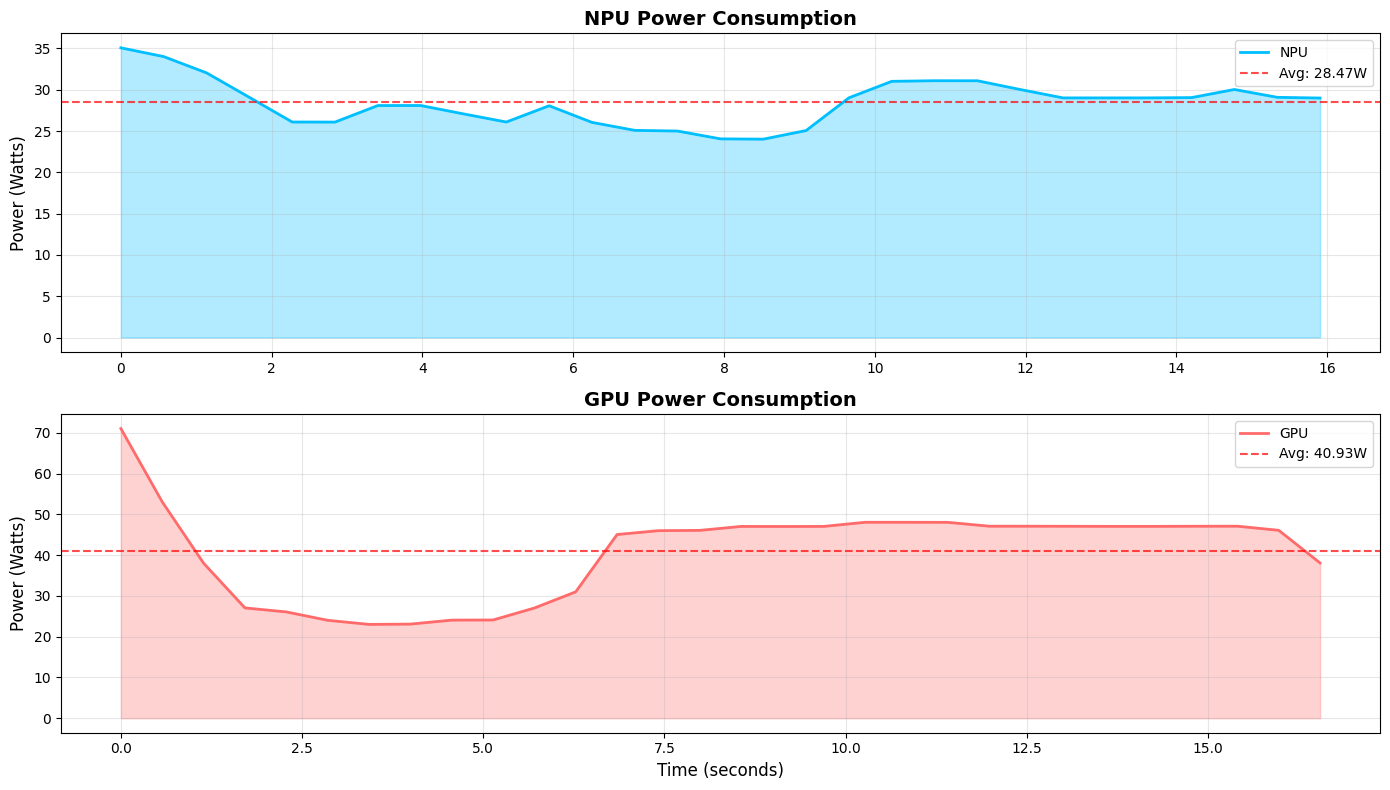

In [9]:
import numpy as np
# Plot power consumption over time
if npu_stats['samples'] and gpu_stats['samples']:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=False)
    
    # NPU power timeline
    npu_time = np.linspace(0, npu_duration, len(npu_stats['samples']))
    ax1.plot(npu_time, npu_stats['samples'], color='#00BFFF', linewidth=2, label='NPU')
    ax1.axhline(npu_stats['avg_power'], color='red', linestyle='--', alpha=0.7, label=f'Avg: {npu_stats["avg_power"]:.2f}W')
    ax1.fill_between(npu_time, npu_stats['samples'], alpha=0.3, color='#00BFFF')
    ax1.set_ylabel('Power (Watts)', fontsize=12)
    ax1.set_title('NPU Power Consumption', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(alpha=0.3)
    
    # GPU power timeline
    gpu_time = np.linspace(0, gpu_stats['duration'], len(gpu_stats['samples']))
    ax2.plot(gpu_time, gpu_stats['samples'], color='#FF6B6B', linewidth=2, label='GPU')
    ax2.axhline(gpu_stats['avg_power'], color='red', linestyle='--', alpha=0.7, label=f'Avg: {gpu_stats["avg_power"]:.2f}W')
    ax2.fill_between(gpu_time, gpu_stats['samples'], alpha=0.3, color='#FF6B6B')
    ax2.set_xlabel('Time (seconds)', fontsize=12)
    ax2.set_ylabel('Power (Watts)', fontsize=12)
    ax2.set_title('GPU Power Consumption', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('power_timeline.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Power timeline not available (insufficient samples)")

## Try other the other features

Let's try another CVML feature - face detection:

## Other things to try

* Inspect depth_estimation_midas - try loading a medium or large variant and compare power
* Try other CVML features, like face detection or face mesh!

For example try:
```
!./build/face_detection_npu -i test_frame.jpg -m fast -o face_npu.jpg
```

In [ ]:
# Run face detection on single image
!./build/face_detection_npu -i test_frame.jpg -m fast -o face_npu.jpg

# Display result
face_result = cv2.imread('face_npu.jpg')
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(face_result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Face Detection (NPU)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Key Takeaways

### When to Use Each Backend

- **NPU**: Best for always-on, power-constrained applications (robotics, edge devices)
- **GPU**: Best for maximum throughput, batch processing
- **CPU**: Fallback option

## Next Steps

Now that you understand how to use CVML and compare backends, in the next notebook we'll integrate these vision features into ROS for building robotic applications.

**Continue to**: [3_cvml_ros.ipynb](3_cvml_ros.ipynb)

## Cleanup (Optional)

Remove generated output files to save space:

In [ ]:
!rm -f output_*.mp4 test_frame.jpg depth_*.jpg face_*.jpg *.png
print("Cleanup complete!")

---
Copyright© 2025 AMD, Inc. SPDX-License-Identifier: MIT